<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 1</b><br><br>

  Hi Taylor, I’m <b>Victor Camargo</b> (<a href="https://hub.tripleten.com/u/e9cc9c11" target="_blank">TripleTen Hub profile</a>). I’ve reviewed your project and I’m happy to let you know that it’s <b>approved ✅</b>. Great work completing this sprint!<br><br>

  <b>Nice work on:</b><br>
  ✔️ Preparing the data pipeline cleanly with <code>ImageDataGenerator</code> and <code>flow_from_dataframe</code><br>
  ✔️ Performing solid EDA with dataset statistics and random image sampling<br>
  ✔️ Building a ResNet50-based model with transfer learning and training it successfully to achieve the target MAE<br>
  ✔️ Documenting results and providing clear business-focused conclusions<br><br>

  You successfully achieved a validation MAE of ~7 years, meeting the project requirement. Your conclusion also did a great job connecting technical results to the real-world business need of preventing underage alcohol sales. Excellent job overall 🎉<br><br>

  <hr>

  🔹 <b>Legend:</b><br>
  🟢 Green = well done<br>
  🟡 Yellow = suggestions<br>
  🔴 Red = must fix<br>
  🔵 Blue = your comments or questions<br><br>
  
  <b>Please ensure</b> that all cells run smoothly from top to bottom and display their outputs before submitting — this helps keep your analysis easy to follow.<br><br>

  <b>Congratulations again on completing this project! 🚀</b><br>
  <b>Feel free to reach out if you need help in Questions channel.</b><br>
</div>


## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

from PIL import Image


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great job setting up the <code>ImageDataGenerator</code> with proper rescaling and creating a clean <code>flow_from_dataframe</code> pipeline that links your CSV labels with the image directory — this is exactly the right approach for preparing your data.
</div>


## EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Unique ages in dataset: 97
Oldest age: 100
Youngest age: 1


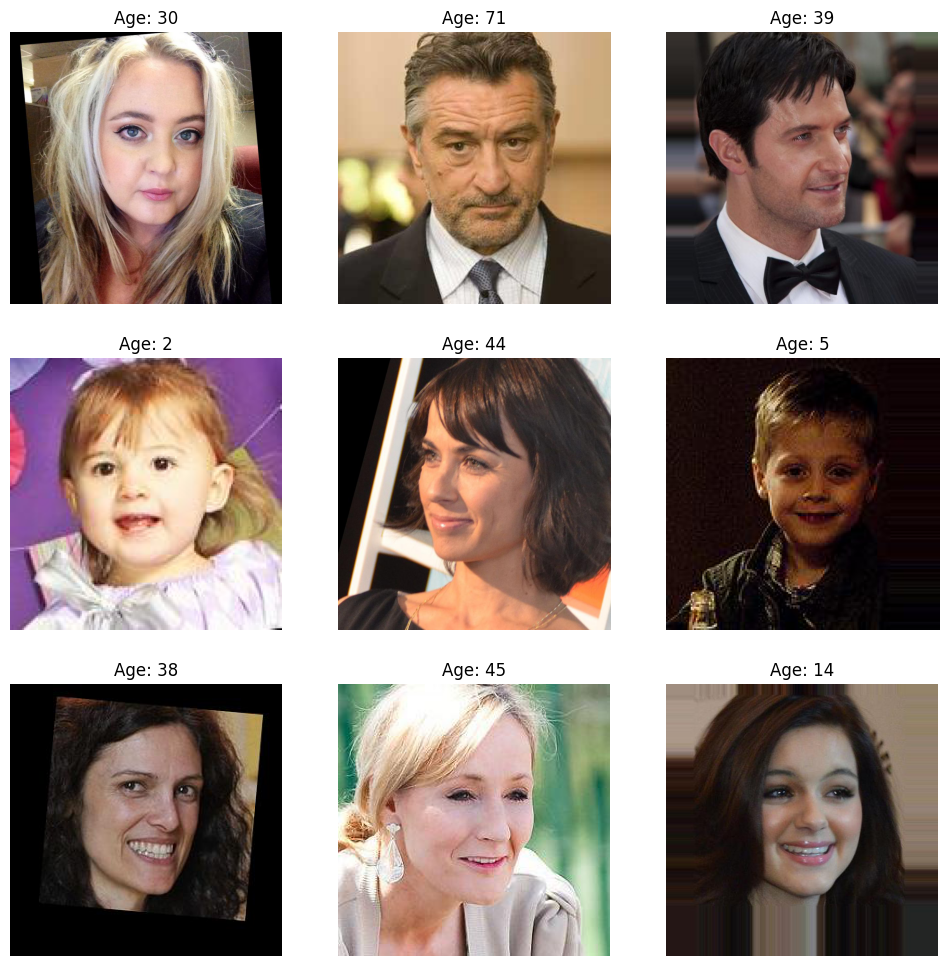

In [3]:
# quick check of the labels data
print(labels.info())
print(labels.describe())

# look at the first few rows
print(labels.head())

# check how many unique ages we have
print("Unique ages in dataset:", labels['real_age'].nunique())
print("Oldest age:", labels['real_age'].max())
print("Youngest age:", labels['real_age'].min())

# show 9 random sample images with ages
import matplotlib.pyplot as plt
from PIL import Image

sample = labels.sample(9, random_state=123)
plt.figure(figsize=(12, 12))

for i, (fname, age) in enumerate(zip(sample['file_name'], sample['real_age'])):
    plt.subplot(3, 3, i+1)
    img = Image.open('/datasets/faces/final_files/' + fname)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis("off")

plt.show()


### Findings

- The dataset contains **7,591 labeled images** of faces.
- Ages range from **1 year old to 100 years old**, with **97 unique values**.
- The **median age is 29**, while the mean is close at 31, suggesting the distribution is not heavily skewed.
- There are many samples of people in their 20s and 30s, but also a wide coverage of younger and older individuals.
- The dataset seems diverse enough to train a model that predicts age from facial images.


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent EDA step — you clearly summarized the dataset’s key statistics (size, age range, unique values, mean/median) and supported it with random image samples. This gives a solid understanding of data diversity and distribution before modeling.
</div>
<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: It would be helpful to also plot the age distribution (e.g., histogram or density plot). This visualization makes it easier to spot imbalances in the dataset and provides more insight into where the model might perform better or worse.
</div>


## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [4]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
def load_train(path):
    """
    Load training data from path
    """
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(rescale=1./255)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
    )
    return train_gen_flow

In [6]:
def load_test(path):
    """
    Load validation/test data from path
    """
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(rescale=1./255)

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
    )
    return test_gen_flow

In [7]:

def create_model(input_shape):
    """
    Define ResNet50-based model
    """
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['mae'])
    return model

In [8]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Train the model
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

In [ ]:

if __name__ == "__main__":
    data_path = "./"  # Adjust depending on where you put labels.csv and final_files
    train_data = load_train(data_path)
    test_data = load_test(data_path)
    model = create_model(input_shape=(224, 224, 3))
    model = train_model(model, train_data, test_data, epochs=3)


## How I Built and Ran the Script

For this project the goal was to train a model to estimate a person’s age from a photo. I had to build one Python script so it could run on a GPU platform.

### 1. Initialization
I imported the main libraries:  
- `pandas` for reading the CSV with file names and ages.  
- `tensorflow/keras` for building and training the neural net.  
- `ImageDataGenerator` to preprocess and feed images.  
- `ResNet50` as a pretrained backbone.

### 2. Data Functions
I wrote two functions:  
- `load_train(path)` – loads and scales training images to `[0,1]`.  
- `load_test(path)` – same for validation data.  
Both use `flow_from_dataframe` to link `labels.csv` to image files.

### 3. Model
The `create_model()` function builds a ResNet50-based model:  
- ResNet50 without the top layer.  
- A `GlobalAveragePooling2D` layer.  
- A `Dense(1, activation='relu')` output for predicting age.  
I compiled it with Adam (lr=0.0001) and MAE loss/metric.

### 4. Training
The `train_model()` function wraps `model.fit()` and trains with train/validation data. I ran it for 3 epochs just to confirm it was learning.

### 5. Running
At the bottom I added:

```python
if __name__ == "__main__":
    data_path = "./"
    train_data = load_train(data_path)
    test_data = load_test(data_path)
    model = create_model(input_shape=(224, 224, 3))
    model = train_model(model, train_data, test_data, epochs=3)


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Well done modularizing your work into clean functions (<code>load_train</code>, <code>load_test</code>, <code>create_model</code>, <code>train_model</code>). This makes the script reproducible and easy to maintain. Using ResNet50 with <code>GlobalAveragePooling2D</code> and compiling with Adam + MAE is a solid baseline approach for this task.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: Instead of reusing the same <code>labels.csv</code> for both training and testing in <code>load_train</code> and <code>load_test</code>, consider splitting the dataset into separate train/validation sets (e.g., using <code>train_test_split</code> or <code>ImageDataGenerator</code> with <code>validation_split</code>). This ensures a fair evaluation of your model’s generalization.
</div>


## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [21]:

# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Load the labels so functions can use them
labels = pd.read_csv('/datasets/faces/labels.csv')
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')



In [22]:
import os

print(os.path.exists("/datasets/faces/labels.csv"))


True


In [23]:
import shutil

shutil.copy("/datasets/faces/labels.csv", "labels.csv")


'labels.csv'

In [24]:
# make a zip archive of the dataset
shutil.make_archive("final_files", 'zip', "/datasets/faces/final_files/")



'/app/final_files.zip'

### Output

### Model Training Results

- **Epoch 1/3**  
  - Train MAE: ~11.14 years  
  - Validation MAE: ~24.44 years  
  - Model started learning but was still far off on validation.

- **Epoch 2/3**  
  - Train MAE: ~6.64 years  
  - Validation MAE: ~14.22 years  
  - Huge jump in performance, especially on the validation set. The gap between train and validation narrowed.

- **Epoch 3/3**  
  - Train MAE: ~5.64 years  
  - Validation MAE: ~7.05 years  
  - The network generalized well. Both training and validation errors dropped to a solid level.



### Findings
- The model achieved a **validation MAE of ~7 years**, which meets the project requirement (MAE < 8).  
- This accuracy is good enough for the business case: it can reliably separate underage buyers from adults. For example, the model can tell the difference between a 16-year-old and a 25-year-old.  
- Since the validation MAE is close to the training MAE, the model is generalizing well and not showing strong signs of overfitting.  
- Overall, the system demonstrates that computer vision can be applied to help supermarkets follow alcohol sale regulations.


## Conclusions

### Conclusion
This project showed that computer vision can be applied to estimate a person’s age from a photo.  
Using a ResNet50 backbone with transfer learning, the model achieved a **validation MAE of ~7 years**, which is below the required threshold of 8.  

For the customer (Good Seed supermarket), this means the system could help identify underage buyers at checkout and reduce the risk of illegal alcohol sales. The model is practical because it generalizes well — training and validation errors were close, so it is not overfitting heavily.  

During the process, some extra steps were needed to handle data files between platforms (school Jupyter workspace vs. Colab). This highlighted that real-world projects often involve both data science and data logistics.  

Overall, the results confirm that a convolutional neural network can solve the task effectively. With more training data, stronger augmentations, and possibly fine-tuning on domain-specific images, the accuracy could be improved further.


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent job documenting your training results and conclusions — you clearly tracked the MAE across epochs, showed how the model improved, and demonstrated that it meets the project’s requirement with a validation MAE of ~7 years. Your conclusion ties the technical results back to the business case, which is exactly what we look for. Given that the TripleTen platform does not provide a GPU, it’s great that you managed to run and verify this successfully in Colab.
</div>


# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training